In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X_train = pd.read_csv("../data/X_test_update.csv", index_col=0)
y_train = pd.read_csv("../data/Y_train_CVw08PX.csv", index_col=0)

In [15]:
X_train.head()

,designation,description,productid,imageid
84916,Folkmanis Puppets - 2732 - Marionnette Et Théâ...,NaN,516376098,1019294171
84917,Porte Flamme Gaxix - Flamebringer Gaxix - 136/...,NaN,133389013,1274228667
84918,Pompe de filtration Speck Badu 95,NaN,4128438366,1295960357
84919,Robot de piscine électrique,<p>Ce robot de piscine d&#39;un design innovan...,3929899732,1265224052
84920,Hsm Destructeur Securio C16 Coupe Crois¿E: 4 X...,NaN,152993898,940543690


In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13812 entries, 84916 to 98727
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  13812 non-null  object
 1   description  8926 non-null   object
 2   productid    13812 non-null  int64 
 3   imageid      13812 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 539.5+ KB


In [19]:
y_train.head()

,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


In [21]:
print(len(y_train.value_counts()))

27


In [25]:
# Réduire X_train à 5% des données
X_train = X_train.sample(frac=0.5, random_state=42)

print("Taille de X_train réduite :", X_train.shape)


Taille de X_train réduite : (3453, 4)


### Traitement des données textuelles

In [27]:
#Ne pas ajouter description pour le moment
X_train["designation_description"] = X_train['designation']


'''# Ajouter la description à la designation si description n'est pas NaN
X_train["designation_description"] = X_train.apply(
    lambda row: f"{row['designation']} - {row['description']}" if pd.notna(row['description']) else row['designation'],
    axis=1
)

# Afficher le DataFrame mis à jour
X_train.head()'''

'# Ajouter la description à la designation si description n\'est pas NaN\nX_train["designation_description"] = X_train.apply(\n    lambda row: f"{row[\'designation\']} - {row[\'description\']}" if pd.notna(row[\'description\']) else row[\'designation\'],\n    axis=1\n)\n\n# Afficher le DataFrame mis à jour\nX_train.head()'

In [29]:
# Detecter les langues présentes

# Solution eventuelle vu qu'il y a bcp d'erreur => d'abord detecter le francais, le mettre dans language_initial
# et ensuite traiter les autres langues où il n'y a pas de francais pour detecter la langue, erreur moins grave si je traduis tout en fr derrière

In [31]:
'''from langdetect import detect, DetectorFactory
from collections import Counter

# Fixer le comportement aléatoire de langdetect
DetectorFactory.seed = 0

# Fonction pour détecter la langue
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"  # Pour les cas où la langue n'est pas détectable

# Appliquer la détection des langues
X_train["language_initial"] = X_train["designation"].apply(detect_language)

# Compter les langues présentes
lang_counts = Counter(X_train["language_initial"])
print("Langues détectées :", lang_counts)

# Afficher les résultats
X_train.head()'''

'from langdetect import detect, DetectorFactory\nfrom collections import Counter\n\n# Fixer le comportement aléatoire de langdetect\nDetectorFactory.seed = 0\n\n# Fonction pour détecter la langue\ndef detect_language(text):\n    try:\n        return detect(text)\n    except:\n        return "unknown"  # Pour les cas où la langue n\'est pas détectable\n\n# Appliquer la détection des langues\nX_train["language_initial"] = X_train["designation"].apply(detect_language)\n\n# Compter les langues présentes\nlang_counts = Counter(X_train["language_initial"])\nprint("Langues détectées :", lang_counts)\n\n# Afficher les résultats\nX_train.head()'

In [33]:
import langid

# Fonction alternative pour détecter la langue
def detect_language_langid(text):
    try:
        return langid.classify(text)[0]
    except:
        return "unknown"

# Appliquer la détection avec langid
X_train["language_langid"] = X_train["designation"].apply(detect_language_langid)

# Comparaison des résultats
X_train[["designation", "language_langid"]].head()


,designation,language_langid
96459,Pompe ultra-flow 075 cv mono,en
93214,Maquillage Cleaner Brosse Dispositif De Nettoy...,fr
91913,Les Artifices Du Vivant,fr
88061,Brosse de tentacule pour robot Polaris 180 280...,fr
97715,Recharger - World Of Warcraft - Champ Honneur ...,en


In [34]:
X_train['language_langid'].value_counts(1).head(20)

language_langid
fr    0.712714
en    0.106864
de    0.025775
nl    0.023168
it    0.021141
es    0.015349
da    0.008688
lb    0.008398
oc    0.007819
la    0.006082
no    0.005213
et    0.004054
ro    0.004054
pt    0.003475
zh    0.002896
pl    0.002896
tl    0.002606
sv    0.002606
eo    0.002317
fi    0.002027
Name: proportion, dtype: float64

In [35]:
# Traduction en francais

In [36]:
import pandas as pd

# Fonction pour tronquer la description si elle dépasse 5000 caractères
def truncate_text(text, max_length=2000, threshold=5000):
    if isinstance(text, str) and len(text) > threshold:  # Vérifie si le texte dépasse le seuil
        return text[:max_length]  # Tronquer à 2000 caractères
    return text  # Sinon, garder le texte tel quel

# Appliquer la fonction à la colonne 'description'
X_train["designation_description"] = X_train["designation_description"].apply(lambda x: truncate_text(x))

# Vérification : Compter les descriptions qui dépassent toujours 5000 caractères
long_texts_count = X_train["designation_description"].apply(lambda x: isinstance(x, str) and len(x) > 5000).sum()

# Afficher le résultat
print(f"Nombre de descriptions dépassant encore 5000 caractères : {long_texts_count}")
print(X_train[["designation_description"]].head())


Nombre de descriptions dépassant encore 5000 caractères : 0
                                 designation_description
96459                       Pompe ultra-flow 075 cv mono
93214  Maquillage Cleaner Brosse Dispositif De Nettoy...
91913                            Les Artifices Du Vivant
88061  Brosse de tentacule pour robot Polaris 180 280...
97715  Recharger - World Of Warcraft - Champ Honneur ...


In [37]:
from deep_translator import GoogleTranslator
import pandas as pd

# Fonction pour traduire en français
def translate_to_french(text):
    try:
        if pd.notna(text):  # Ne traduire que si le texte n'est pas NaN
            return GoogleTranslator(source='auto', target='fr').translate(text)
        else:
            return text
    except Exception as e:
        print(f"Erreur de traduction pour le texte : {text} | Erreur : {e}")
        return text

# Appliquer la traduction à la colonne 'designation_description'
X_train["designation_description_fr"] = X_train["designation_description"].apply(translate_to_french)

In [42]:
X_train[["designation_description", "designation_description_fr"]].head(120)

,designation_description,designation_description_fr
96459,Pompe ultra-flow 075 cv mono,Pompe ultra-flow 075 cv mono
93214,Maquillage Cleaner Brosse Dispositif De Nettoy...,Maquillage Cleaner Brosse Dispositif De Nettoy...
91913,Les Artifices Du Vivant,Les Artifices Du Vivant
88061,Brosse de tentacule pour robot Polaris 180 280...,Brosse de tentacule pour robot Polaris 180 280...
97715,Recharger - World Of Warcraft - Champ Honneur ...,Recharger - World Of Warcraft - Champ Honneur ...
...,...,...
88190,7.4v 1300mah Batterie Au Lithium Pour Syma W1 ...,7.4v 1300mah Batterie Au Lithium Pour Syma W1 ...
97854,Buyiesky®Girafe En Peluche Cher Doux Poupées A...,Buyiesky®Girafe En Peluche Cher Doux Poupées A...
89007,Pharaon Égyptien Ancien Hooded Couverture Couv...,Pharaon Égyptien Ancien Hooded Couverture Couv...
92917,Yu-Gi-Oh -Duplication De Sort - Dcr - Fr083 - C,Yu-Gi-Oh -Duplication De Sort - Dcr - Fr083 - C


In [43]:
# Lemmatiser

In [44]:
import spacy

# Charger le modèle de langue française optimisé
nlp = spacy.load("fr_core_news_sm")

# Exemple de données
# X_train = pd.DataFrame({'designation_description_fr': ["Ceci est une phrase.", "Les enfants jouent dans le parc.", None]})

# Lemmatisation optimisée avec nlp.pipe
def lemmatiser_colonne(df, colonne):
    """
    Lemmatiser les phrases d'une colonne en batch pour optimiser la vitesse.
    Args:
        df (pd.DataFrame): Le DataFrame.
        colonne (str): Le nom de la colonne à lemmatiser.
    Returns:
        list: Une liste des textes lemmatisés.
    """
    # Remplacer les NaN par des chaînes vides temporairement pour éviter les erreurs
    textes = df[colonne].fillna("")

    # Utiliser nlp.pipe pour traiter les textes en batch
    docs = nlp.pipe(textes, batch_size=50, n_process=4)  # batch_size et n_process ajustables

    # Extraire les lemmes de chaque texte
    lemmatized_texts = [" ".join([token.lemma_ for token in doc]) for doc in docs]

    return lemmatized_texts

# Appliquer la fonction à la colonne 'designation_description_fr'
X_train['designation_description_fr_lemmatized'] = lemmatiser_colonne(X_train, 'designation_description_fr')

# Afficher les résultats
X_train[['designation_description_fr', 'designation_description_fr_lemmatized']].head()

,designation_description_fr,designation_description_fr_lemmatized
96459,Pompe ultra-flow 075 cv mono,Pompe ultra-flow 075 cv mono
93214,Maquillage Cleaner Brosse Dispositif De Nettoy...,maquillage Cleaner Brosse Dispositif de nettoy...
91913,Les Artifices Du Vivant,le artifice de Vivant
88061,Brosse de tentacule pour robot Polaris 180 280...,brosse de tentacule pour robot Polaris 180 280...
97715,Recharger - World Of Warcraft - Champ Honneur ...,recharger - World of Warcraft - champ honneur ...


In [45]:
# Gérer les stop words en anglais au cas ou et francais

In [46]:
import pandas as pd
import spacy

# Charger les modèles français et anglais
nlp_fr = spacy.load("fr_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

# Fusionner les stopwords des deux langues
stopwords_fr = nlp_fr.Defaults.stop_words
stopwords_en = nlp_en.Defaults.stop_words
stopwords_combined = stopwords_fr.union(stopwords_en)  # Union des stopwords FR + EN

# Fonction pour supprimer les stopwords
def filtrer_stopwords_multilangue(texte):
    if isinstance(texte, str):  # Vérifier si le texte est valide
        mots = texte.split()  # Diviser le texte en mots
        # Filtrer les mots qui ne sont pas dans les stopwords
        mots_filtres = [mot for mot in mots if mot.lower() not in stopwords_combined]
        return " ".join(mots_filtres)  # Rejoindre les mots filtrés
    return None  # Retourner None si NaN

# Appliquer la fonction à la colonne 'designation_description_fr_lemmatized'
X_train['designation_description_fr_cleaned'] = X_train['designation_description_fr_lemmatized'].apply(filtrer_stopwords_multilangue)

# Afficher les résultats
X_train[['designation_description_fr_lemmatized', 'designation_description_fr_cleaned']].head()

,designation_description_fr_lemmatized,designation_description_fr_cleaned
96459,Pompe ultra-flow 075 cv mono,Pompe ultra-flow 075 cv mono
93214,maquillage Cleaner Brosse Dispositif de nettoy...,maquillage Cleaner Brosse Dispositif nettoyage...
91913,le artifice de Vivant,artifice Vivant
88061,brosse de tentacule pour robot Polaris 180 280...,brosse tentacule robot Polaris 180 280 380 390...
97715,recharger - World of Warcraft - champ honneur ...,recharger - World Warcraft - champ honneur 31 - u


In [47]:
import re

def nettoyer_texte_colonne(df, colonne):
    """
    Nettoie une colonne texte en supprimant les symboles et ponctuations indésirables.

    Args:
        df (pd.DataFrame): DataFrame contenant la colonne à nettoyer.
        colonne (str): Nom de la colonne à nettoyer.

    Returns:
        pd.DataFrame: DataFrame avec la colonne nettoyée.
    """
    def nettoyer_texte(texte):
        if isinstance(texte, str):
            # Supprimer tous les caractères non-alphanumériques sauf les espaces
            return re.sub(r'[^\w\s]', '', texte)
        return texte  # Retourner inchangé si ce n'est pas une chaîne

    # Appliquer le nettoyage à la colonne
    df[colonne] = df[colonne].apply(nettoyer_texte)
    return df

# Exemple d'application
# Nettoyer la colonne 'designation_description_fr_cleaned' dans votre DataFrame
X_train = nettoyer_texte_colonne(X_train, 'designation_description_fr_cleaned')

# Afficher les premières lignes pour vérifier le nettoyage
X_train[['designation_description_fr_cleaned']].head()

,designation_description_fr_cleaned
96459,Pompe ultraflow 075 cv mono
93214,maquillage Cleaner Brosse Dispositif nettoyage...
91913,artifice Vivant
88061,brosse tentacule robot Polaris 180 280 380 390...
97715,recharger World Warcraft champ honneur 31 u


### Visualisation et exploration des données textuelles

à ce niveau, j'ai toutes mes données traduites, lemmatisées et avec les stopwords en anglais (par précaussion) et en français

In [49]:
# Faire le nuage de point

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from collections import Counter

def generate_wordcloud_top_words(X_train, y_train, categories, colormap='viridis'):
    """
    Génère un WordCloud pour chaque catégorie avec les mots les plus fréquents
    et l'affiche dans un graphe interactif avec Plotly.

    Args:
        X_train (pd.DataFrame): DataFrame contenant la colonne nettoyée 'designation_description_fr_cleaned'.
        y_train (pd.DataFrame): DataFrame contenant la colonne 'prdtypecode'.
        categories (list): Liste des catégories à inclure.
        colormap (str): Nom de la colormap matplotlib pour le WordCloud.
    """
    # Fusionner X_train et y_train sur l'index
    merged_df = pd.merge(X_train, y_train, left_index=True, right_index=True)

    # Supprimer les lignes avec des descriptions manquantes
    merged_df = merged_df.dropna(subset=['designation_description_fr_cleaned'])

    # Placeholder pour les WordClouds
    wordcloud_images = {}

    for category in categories:
        # Filtrer les données par catégorie
        category_df = merged_df[merged_df['prdtypecode'] == category]

        if category_df.empty:
            print(f"Aucune description trouvée pour la catégorie '{category}'.")
            continue

        # Combiner les descriptions
        text = " ".join(category_df['designation_description_fr_cleaned'].astype(str))

        # Compter les fréquences des mots
        word_counts = Counter(text.split())  # Compte les mots dans le texte
        top_words = dict(word_counts.most_common(10))  # Conserver les 10 mots les plus fréquents

        # Créer le WordCloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color="white",
            colormap=colormap
        ).generate_from_frequencies(top_words)

        # Stocker l'image du WordCloud
        wordcloud_images[category] = wordcloud

    # Créer un graphe interactif avec Plotly
    fig = go.Figure()

    for category, wordcloud in wordcloud_images.items():
        # Convertir le WordCloud en image
        img = wordcloud.to_array()

        fig.add_trace(go.Image(z=img, name=str(category), visible=True))

    # Ajouter un menu déroulant pour changer de catégorie
    fig.update_layout(
        title="WordCloud Interactif (Top 10 mots par catégorie)",
        updatemenus=[
            dict(
                type="dropdown",
                direction="down",
                x=0.5,
                y=1.15,
                buttons=[
                    dict(label="Tous",
                         method="update",
                         args=[{"visible": [True] * len(wordcloud_images)},
                               {"title": "Toutes les catégories"}]),
                    *[dict(label=str(cat),
                           method="update",
                           args=[{"visible": [cat == c for c in wordcloud_images.keys()]},
                                 {"title": f"Catégorie : {cat}"}])
                      for cat in wordcloud_images.keys()]
                ]
            )
        ]
    )

    fig.show()


In [51]:
#generate_wordcloud_top_words(X_train,y_train,y_train.prdtypecode.unique(),colormap='viridis')

In [52]:
# Affichage des catégories pour pouvoir explorer les différents nuages de mots
print(y_train.prdtypecode.unique())

[  10 2280   50 1280 2705 2522 2582 1560 1281 1920 2403 1140 2583 1180
 1300 2462 1160 2060   40   60 1320 1302 2220 2905 2585 1940 1301]


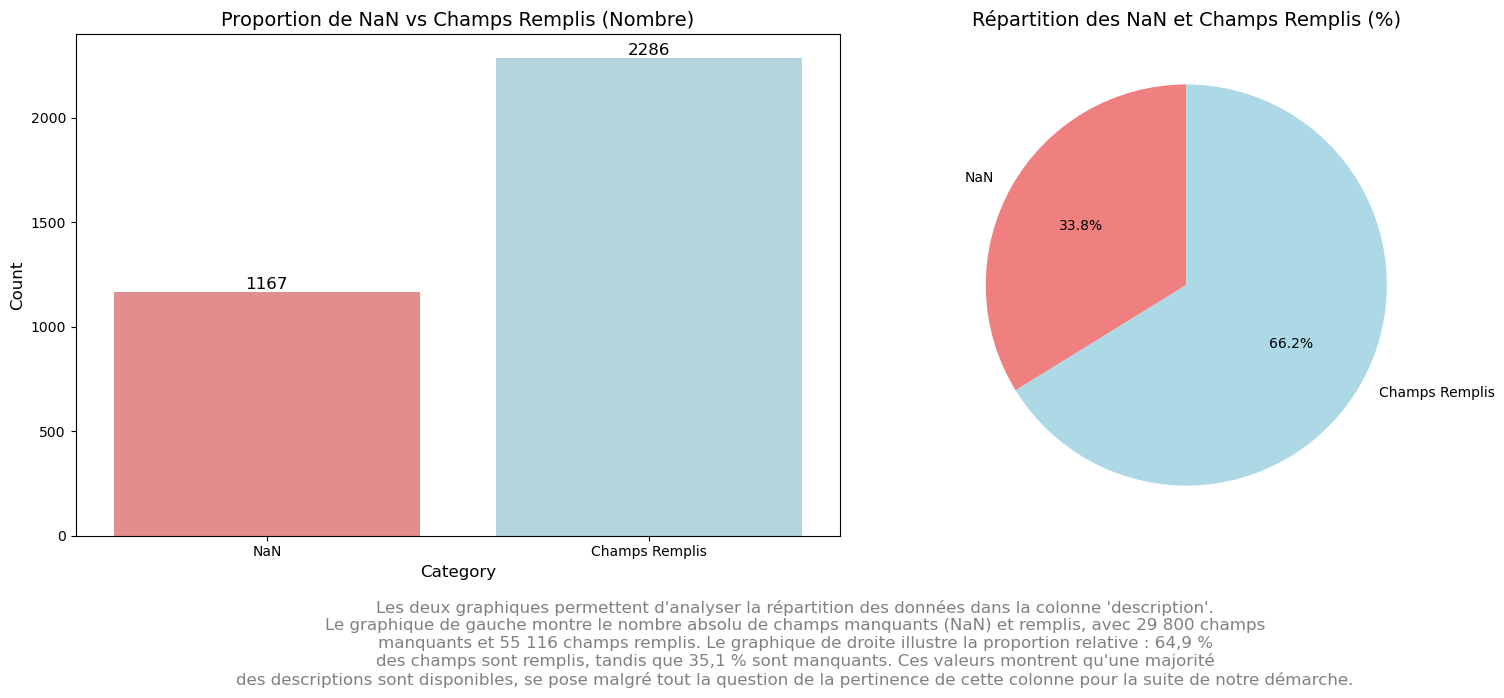

In [53]:
# Calculer le nombre de NaN et non-NaN
nan_count = X_train['description'].isna().sum()
not_nan_count = X_train['description'].notna().sum()

# Créer un DataFrame pour la visualisation
data_proportion = pd.DataFrame({
    'Category': ['NaN', 'Champs Remplis'],
    'Count': [nan_count, not_nan_count]
})
data_proportion

import seaborn as sns

# Calculer les proportions pour le camembert
labels = ['NaN', 'Champs Remplis']
sizes = [nan_count, not_nan_count]  # Les valeurs brutes pour chaque catégorie

# Définir les couleurs (les mêmes pour les deux graphiques)
colors = ['lightcoral', 'lightblue']

# Créer une figure avec deux graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

# Graphique 1 : Comptage des NaN et des Champs Remplis (Barplot)
sns.barplot(data=data_proportion, x='Category', y='Count', palette=colors, ax=axes[0])
axes[0].set_title('Proportion de NaN vs Champs Remplis (Nombre)', fontsize=14)
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Ajouter des annotations au-dessus des barres (Graphique 1)
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=12, color='black')

# Graphique 2 : Camembert (Pie chart)
axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Répartition des NaN et Champs Remplis (%)', fontsize=14)

# Ajouter une description sous les graphiques
fig.text(0.5, -0.15,
         "Les deux graphiques permettent d'analyser la répartition des données dans la colonne 'description'.\n"
         "Le graphique de gauche montre le nombre absolu de champs manquants (NaN) et remplis, avec 29 800 champs\n"
         "manquants et 55 116 champs remplis. Le graphique de droite illustre la proportion relative : 64,9 %\n"
         "des champs sont remplis, tandis que 35,1 % sont manquants. Ces valeurs montrent qu'une majorité\n"
         "des descriptions sont disponibles, se pose malgré tout la question de la pertinence de cette colonne pour la suite de notre démarche.",
         ha='center', fontsize=12, color='gray')

# Ajuster l'espace entre les graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()


In [54]:
#Sortir le nm moyen de mots dans chaque commentaire
#Trop de mots dans les commentaires, cela demande beaucoup plus de ressources
# et peut surcharger en information notre modèle

In [55]:
import pandas as pd

# Fonction pour compter les mots dans une chaîne de texte
def compter_mots(texte):
    if isinstance(texte, str):  # Vérifier si c'est une chaîne valide
        return len(texte.split())  # Diviser par les espaces et compter les mots
    return None  # Retourner None pour les valeurs NaN

# Appliquer la fonction et ignorer les NaN
description_moyenne = X_train['description'].dropna().apply(lambda x: len(x.split())).mean()
designation_moyenne = X_train['designation'].dropna().apply(lambda x: len(x.split())).mean()

# Afficher les résultats
print(f"Nombre moyen de mots dans 'description' : {description_moyenne:.2f}")
print(f"Nombre moyen de mots dans 'designation' : {designation_moyenne:.2f}")


Nombre moyen de mots dans 'description' : 123.02
Nombre moyen de mots dans 'designation' : 11.54


## Enregistrer les données

In [57]:
import pickle
import os

# Chemin relatif pour enregistrer dans ../data/
directory = "../data"
filename = "X_test_clean.pkl"

filepath = os.path.join(directory, filename)


# Vérifier si le répertoire existe, sinon le créer
if not os.path.exists(directory):
    os.makedirs(directory)

# Enregistrement du DataFrame X_train en pickle
with open(filepath, "wb") as file:
    pickle.dump(X_train, file)

print(f"enregistré avec succès dans {filepath}")

enregistré avec succès dans ../data\X_test_clean.pkl


## Encodage des données (embeddings)

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer
# =====================================
# Méthode 1 : Encodage avec Vectorizer
# =====================================
def encodage_vectorizer(data, max_features=5000):
    """
    Encodage avec TfidfVectorizer sur les données textuelles.
    
    Args:
        data (pd.Series): Série pandas contenant les textes.
        max_features (int): Nombre maximum de mots les plus fréquents.
    
    Returns:
        scipy.sparse.csr_matrix: Matrice d'encodage.
        TfidfVectorizer: L'objet vectorizer entraîné.
    """
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_vectorized = vectorizer.fit_transform(data)
    return X_vectorized, vectorizer

# Encodage Vectorizer
X_vectorized, vectorizer = encodage_vectorizer(X_train['designation_description_fr_cleaned'])

print("Encodage classique avec Vectorizer :")
print(X_vectorized.shape)  # Dimensions de la matrice encodée
print("Exemple de mots fréquents :", vectorizer.get_feature_names_out()[:10])

Encodage classique avec Vectorizer :
(8492, 5000)
Exemple de mots fréquents : ['000' '009' '01' '01051997' '01071987' '0110' '02' '03' '032' '03mp']


In [126]:
# =====================================
# Méthode 2 : Encodage avec SpaCy
# =====================================
def encodage_spacy(data, model_name='fr_core_news_md', token_dim=96, max_tokens=96):
    """
    Encodage avec vecteurs SpaCy pré-entraînés.
    
    Args:
        data (pd.Series): Série pandas contenant les textes.
        model_name (str): Modèle SpaCy à utiliser.
        token_dim (int): Taille du vecteur pour chaque mot.
        max_tokens (int): Nombre maximum de tokens par texte.
    
    Returns:
        np.array: Tableau 3D d'encodage (n_samples, max_tokens, token_dim).
    """
    nlp = spacy.load(model_name)  # Charger le modèle SpaCy
    embeddings = []
    
    for doc in nlp.pipe(data, batch_size=32):
        # Extraire les vecteurs pour les tokens jusqu'à max_tokens
        token_vectors = np.array([token.vector[:token_dim] for token in doc[:max_tokens]])
        
        # Compléter avec des zéros si moins de max_tokens
        if len(token_vectors) < max_tokens:
            padding = np.zeros((max_tokens - len(token_vectors), token_dim))
            token_vectors = np.vstack([token_vectors, padding])
        
        embeddings.append(token_vectors)
    
    return np.array(embeddings)

# Encodage SpaCy
X_spacy = encodage_spacy(X_train['designation_description_fr_cleaned'])

print("\nEncodage avec SpaCy :")
print("Taille des données encodées :", X_spacy.shape)  # Shape: (n_samples, max_tokens, token_dim)
print("Exemple d'encodage pour un commentaire :", X_spacy[0].shape)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 96

In [ ]:
# =====================================
# Comparaison des deux méthodes
# =====================================
print("\nRésumé :")
print(f"Encodage Vectorizer : {X_vectorized.shape} (matrice creuse)")
print(f"Encodage SpaCy : {X_spacy.shape} (matrice dense)")

## Tests Deep learning

In [ ]:
'''import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Reshape, Conv1D, MaxPooling1D, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report'''

In [ ]:
'''# Découpage en train/test pour les deux encodages
X_vectorized_train, X_vectorized_test, y_train, y_test = train_test_split(
    X_vectorized, y_train_one_hot, test_size=0.2, random_state=42
)

X_spacy_train, X_spacy_test, _, _ = train_test_split(
    X_spacy, y_train_one_hot, test_size=0.2, random_state=42
)
'''

In [ ]:
'''def build_dense_model(input_shape, output_shape):
    model = Sequential()
    model.add(Dense(128, input_dim=input_shape, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Créer et entraîner le modèle
dense_model = build_dense_model(X_vectorized_train.shape[1], y_train.shape[1])
print("Entraînement du modèle Dense avec Vectorizer...")
dense_history = dense_model.fit(
    X_vectorized_train, y_train, validation_data=(X_vectorized_test, y_test), epochs=10, batch_size=32, verbose=1
)
'''

In [ ]:
'''def build_cnn_model(input_shape, output_shape):
    input_layer = Input(shape=(input_shape[1], input_shape[2]))
    
    # Couches convolutionnelles
    conv1 = Conv1D(128, 3, activation='relu')(input_layer)
    pool1 = MaxPooling1D(2)(conv1)
    conv2 = Conv1D(64, 3, activation='relu')(pool1)
    pool2 = MaxPooling1D(2)(conv2)
    
    flatten = Flatten()(pool2)
    dropout = Dropout(0.5)(flatten)
    output_layer = Dense(output_shape, activation='softmax')(dropout)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Créer et entraîner le modèle
cnn_model = build_cnn_model(X_spacy_train.shape, y_train.shape[1])
print("\nEntraînement du modèle CNN avec SpaCy...")
cnn_history = cnn_model.fit(
    X_spacy_train, y_train, validation_data=(X_spacy_test, y_test), epochs=10, batch_size=32, verbose=1
)
'''

In [ ]:
"""# Évaluer le modèle Dense
print("\nÉvaluation du modèle Dense :")
dense_eval = dense_model.evaluate(X_vectorized_test, y_test, verbose=0)
print(f"Loss: {dense_eval[0]:.4f}, Accuracy: {dense_eval[1]:.4f}")

# Évaluer le modèle CNN
print("\nÉvaluation du modèle CNN :")
cnn_eval = cnn_model.evaluate(X_spacy_test, y_test, verbose=0)
print(f"Loss: {cnn_eval[0]:.4f}, Accuracy: {cnn_eval[1]:.4f}")

# Comparaison des résultats
print("\nComparaison des performances :")
print(f"Modèle Dense (Vectorizer) - Accuracy : {dense_eval[1]:.4f}")
print(f"Modèle CNN (SpaCy)      - Accuracy : {cnn_eval[1]:.4f}")
"""